# Feature Engineering 

**Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. If feature engineering is done correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process. Feature Engineering is an art.**

In [30]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

#import machine learning
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import datetime as dt
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectFromModel


In [31]:
df_final = pd.read_csv(r"C:\Users\1\Documents\DataScience-Python3\kickstarter-projects/ks-projects-201801.csv")
df_final.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Datatypes

In [32]:
#Converting datatype "object" to "datetime" in "deadline", and "launched" columns 
df_final.deadline = pd.to_datetime(df_final.deadline, errors = 'coerce', format="%Y/%m/%d").dt.date
df_final.launched = pd.to_datetime(df_final.launched, errors = 'coerce', format="%Y/%m/%d").dt.date 

# Misentered Data

In [33]:
# excluding N,0" from df
df_final= df_final[df_final['country'] != 'N,0"'] 
df_final.country.value_counts() 

US    292627
GB     33672
CA     14756
AU      7839
DE      4171
FR      2939
IT      2878
NL      2868
ES      2276
SE      1757
MX      1752
NZ      1447
DK      1113
IE       811
CH       761
NO       708
HK       618
BE       617
AT       597
SG       555
LU        62
JP        40
Name: country, dtype: int64

In [34]:
#dropping null values
df_final = df_final.dropna() 

In [35]:
# deletting other states
df_final = df_final[df_final.state != "live"]
df_final = df_final[df_final.state != "canceled"] 
df_final = df_final[df_final.state != "suspended"] 


In [36]:
df_final['launch_month']=pd.to_datetime(df_final['launched'], format="%Y/%m/%d").dt.month 
df_final['launch_day']=pd.to_datetime(df_final['launched'], format="%Y/%m/%d").dt.dayofweek

**creating column based on launch month<br>
creating column based on launch day of week**

# Encoding country

In [37]:
#creating feature to indictate whether project was made in US or not
df_final['US'] = np.where(df_final.country=='US', 1, 0)

**Since we have way more data on US kickstarters than any other country, its better to create a feature divides the set into US kickstarters and kickstarters from other countries to help balance our country data out.**

# Encoding 'Main category'

In [38]:
df_final.groupby(['main_category']).size()

main_category
Art             25640
Comics           9878
Crafts           7818
Dance            3573
Design          25363
Fashion         19774
Film & Video    56503
Food            22054
Games           28520
Journalism       4148
Music           45801
Photography      9689
Publishing      35413
Technology      27046
Theater         10242
dtype: int64

In [39]:
# Using Target_Encoder to transform the nominal feature to numeric
X = df_final.main_category
y = df_final.backers

ce_m_category = ce.TargetEncoder(cols = ['main_category'])

ce_m_category.fit(X, y)

df_final['main_category'] = ce_m_category.transform(X, y)

**We got the average number of project backers in each main category**

# Encoding 'category'

In [40]:
#Creating new feature "Average check", based on usd_pledged_real and backers
df_final['avg_check'] = (df_final['usd_pledged_real'] / (df_final['backers']+0.00000000000000001))

In [41]:
# Using Target_Encoder to transform the nominal feature to numeric

X13 = df_final.category
y13 = df_final.avg_check

ce_category = ce.TargetEncoder(cols = ['category'])
ce_category.fit(X13, y13)

df_final['category'] = ce_category.transform(X13, y13)
df_final.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launch_month,launch_day,US,avg_check
0,1000002330,The Songs of Adelaide & Abullah,33.239460,61.821647,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,0.0,0.0,1533.95,8,1,0,0.000000
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,100.631673,72.585066,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,100.0,2421.0,30000.00,9,5,1,161.400000
2,1000004038,Where is Hank?,100.631673,72.585066,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,220.0,220.0,45000.00,1,5,1,73.333333
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,61.899800,58.351543,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,1.0,1.0,5000.00,3,5,1,1.000000
5,1000014025,Monarch Espresso Bar,69.275188,58.954158,USD,2016-04-01,50000.0,2016-02-26,52375.0,successful,224,US,52375.0,52375.0,50000.00,2,4,1,233.816964


**We encode "category" feature by average check**

# Making target culumn->Successful(1,0)

In [42]:
#denotes whether campaign was sucessful or not
df_final['successful'] = np.where(df_final.state == 'successful', 1, 0) 

**Lets add a column to the dataframe to reflect whether or not a campaign was successful.**

# Scaling (usd_goal_real)

In [43]:
scaled_df=df_final.copy()

In [44]:
scaled_df.usd_goal_real = StandardScaler().fit_transform(scaled_df[['usd_goal_real']])
scaled_df.main_category = StandardScaler().fit_transform(scaled_df[['main_category']])
scaled_df.category = StandardScaler().fit_transform(scaled_df[['category']])

# Stratified Shuffle Split

In [45]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_final, df_final["successful"]):
    strat_train_set = df_final.iloc[train_index]
    strat_test_set = df_final.iloc[test_index]
strat_test_set.head()

valid_df = strat_test_set

df_final = strat_train_set

**Using Stratified Shuffle Split to divide our data to validation and train-test data**


# Deletting outliers (viral projects and zero-backer projects)

In [46]:
df_final=df_final.drop(index=[23404])
df_final=df_final.drop(index=[75900])
df_final=df_final.drop(index=[148585])
df_final=df_final.drop(index=[182657])
df_final=df_final.drop(index=[187652])
df_final=df_final.drop(index=[292244])
df_final=df_final.drop(index=[250254])
df_final=df_final.drop(index=[282416])
df_final=df_final.drop(index=[289915])
df_final=df_final.drop(index=[293861])

**We removed outliers in "backers" and ""usd_pledged_real" columns as they were anomalies (from Data Wrangling)**

In [47]:
df_final[df_final.backers == 0]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,launch_month,launch_day,US,avg_check,successful
177995,1905648234,English-language version of my book,5.302493e+01,61.821647,EUR,2015-07-11,15000.0,2015-06-11,0.0,failed,0,DE,0.0,0.0,16333.46,6,3,0,0.0,0
48411,1246853764,Kings of NYC : New york city fitness competition,4.636488e+01,72.585066,USD,2017-09-01,3500.0,2017-07-06,0.0,failed,0,US,0.0,0.0,3500.00,7,3,1,0.0,0
232626,252329171,Inflate.A.Smile Balloon Gifts and Decorations,5.280567e+01,45.424025,AUD,2015-05-03,500.0,2015-04-03,0.0,failed,0,AU,0.0,0.0,395.63,4,4,0,0.0,0
184548,193979394,Music of My Heart,5.890601e+01,58.351543,USD,2016-12-09,11000.0,2016-11-11,0.0,failed,0,US,0.0,0.0,11000.00,11,4,1,0.0,0
222123,2131605546,Sanchez Running,4.568210e+01,382.116655,CAD,2015-11-13,500.0,2015-10-14,0.0,failed,0,CA,0.0,0.0,375.80,10,2,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177420,1902477165,SAFETOMOVE.ORG,1.003509e+02,186.174481,USD,2016-06-06,15000.0,2016-05-07,0.0,failed,0,US,0.0,0.0,15000.00,5,5,1,0.0,0
284927,519633552,Take my hand....,8.307189e+01,44.790372,GBP,2014-09-15,2500.0,2014-07-30,0.0,failed,0,GB,0.0,0.0,4085.17,7,2,0,0.0,0
331407,758374680,Help me Kick Start My Mobile App Business Idea!!!,5.157450e+01,186.174481,USD,2015-05-21,2500.0,2015-04-21,0.0,failed,0,US,0.0,0.0,2500.00,4,1,1,0.0,0
275818,473400040,A Quest For Comedy,1.162656e+13,72.585066,USD,2011-12-30,500.0,2011-11-30,0.0,failed,0,US,0.0,0.0,500.00,11,2,1,0.0,0


In [48]:
#Deletting values, where are zero-backers
df_final = df_final[df_final.backers != 0]

# Dropping columns

In [49]:
to_drop= ['ID','name',"currency", "deadline", "goal", "launched", "usd pledged", "pledged",
           "usd_pledged_real", "state","backers", 'avg_check', 'country']

In [50]:
df_final.drop(to_drop, axis=1, inplace=True)

In [51]:
valid_df.drop(to_drop, axis=1, inplace=True)

In [52]:
valid_df.head()

,category,main_category,usd_goal_real,launch_month,launch_day,US,successful
318084,6.292030e+01,68.452716,5000.00,12,0,1,0
54253,3.190776e+01,29.851113,1137.05,9,3,0,0
270472,5.056555e+01,29.851113,11074.20,3,0,0,0
32399,6.885630e+12,72.585066,1600.00,2,1,1,1
21393,6.799627e+01,43.229951,17647.47,7,2,0,1


# Correlation matrix

In [53]:
df_final.groupby(['successful']).size()

successful
0    142970
1    120456
dtype: int64

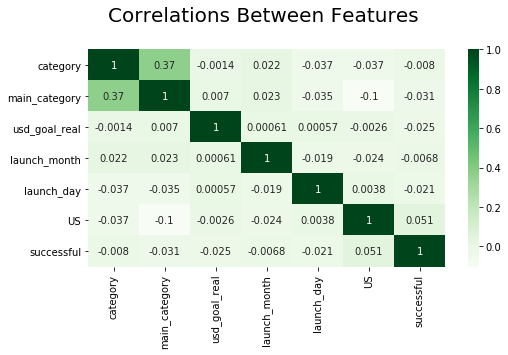

In [54]:
plt.figure(figsize=(8,4))
ax = sns.heatmap(df_final.corr(), cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlations Between Features \n', fontsize = 20)
plt.show()

In [55]:
#Saving our models 
df_final.to_csv("G_train_kickstarter.csv", index=False)
valid_df.to_csv("G_valid_kickstarter.csv", index=False)